# Trying to model ignition delay from RMG for Iso-octane



In [1]:
import sys
sys.path.append('/home/ajulu.c/anaconda3/envs/flame_env')

In [2]:
!which python
!conda list flame_env

/home/ajulu.c/anaconda3/envs/flame_env/bin/python
# packages in environment at /home/ajulu.c/anaconda3/envs/flame_env:
#
# Name                    Version                   Build  Channel


In [3]:
import cantera as ct
import numpy as np
%matplotlib inline

from matplotlib import pyplot as plt

ct.__version__

'2.4.0'

In [4]:
cat /home/ajulu.c/Code/GTL/ic8/chemkin/chem_annotated.inp


ELEMENTS
	H
	D /2.014/
	T /3.016/
	C
	CI /13.003/
	O
	OI /18.000/
	N
	Ne
	Ar
	He
	Si
	S
	Cl
END

SPECIES
    N2                  ! N2
    Ar                  ! Ar
    Ne                  ! Ne
    iC8H18(1)           ! iC8H18(1)
    O2(2)               ! O2(2)
    CH(3)               ! CH(3)
    C2H(4)              ! C2H(4)
    O(5)                ! O(5)
    CO(6)               ! CO(6)
    CO2(7)              ! CO2(7)
    H2O(8)              ! H2O(8)
    CH2O(9)             ! CH2O(9)
    CH4(10)             ! CH4(10)
    C2H4(11)            ! C2H4(11)
    C3H6(12)            ! C3H6(12)
    H2(13)              ! H2(13)
    iC4H8(14)           ! iC4H8(14)
    H(15)               ! H(15)
    OH(16)              ! OH(16)
    He(17)              ! He(17)
    HO2(18)             ! HO2(18)
    H2O2(19)            ! H2O2(19)
    CH3(20)             ! CH3(20)
    HCO(21)             ! HCO(21)
    CH3CO(22)           ! CH3CO(22)
    CH2CHO(23)          ! CH2CHO(23)
    C2H3(24)            ! C2H3(

    CHEB/ -3.279e+01   1.996e+00    -2.809e-03   -1.554e-03  /
    CHEB/ 3.286e+01    3.063e-03    2.125e-03    1.173e-03   /
    CHEB/ -1.020e-01   3.726e-04    2.598e-04    1.447e-04   /
    CHEB/ -5.817e-02   -3.510e-05   -2.404e-05   -1.299e-05  /
    CHEB/ -1.792e-02   -4.801e-05   -3.334e-05   -1.844e-05  /
    CHEB/ -1.483e-03   -3.121e-05   -2.171e-05   -1.204e-05  /

! Reaction index: Chemkin #852; RMG #2153
! Library reaction: CurranPentane
! Flux pairs: S(282), S(351); 
S(282)=S(351)                                       9.820000e+07 1.300     21.500   

! Reaction index: Chemkin #853; RMG #2160
! Library reaction: CurranPentane
! Flux pairs: S(351), CH2O(9); S(351), C3H6(12); S(351), OH(16); 
S(351)=>CH2O(9)+C3H6(12)+OH(16)                     8.451000e+15 -0.680    29.170   

! Reaction index: Chemkin #854; RMG #3778
! Template reaction: 1,2_Insertion_carbene
! Flux pairs: CH2(S)(30), S(674); S(351), S(674); 
! Estimated using an average for rate rule [carbene;R_H]
! Eucli

CH2O(9)+S(3361)=HCO(21)+S(6044)                     4.120000e+04 2.500     10.210   

! Reaction index: Chemkin #2048; RMG #37976
! Template reaction: H_Abstraction
! Flux pairs: S(3361), S(6044); iC4H8(14), IC4H7(288); 
! Estimated using template [C/H3/Cd;O_rad/NonDeO] for rate rule [C/H3/Cd\Cs_Cd\H2;OOC]
! Euclidian distance = 1.41421356237
! Multiplied by reaction path degeneracy 6.0
! family: H_Abstraction
iC4H8(14)+S(3361)=IC4H7(288)+S(6044)                3.469980e-03 4.650     9.780    

! Reaction index: Chemkin #2049; RMG #38333
! Template reaction: H_Abstraction
! Flux pairs: S(3361), S(6044); S(1596), S(1543); 
! Estimated using template [O/H/NonDeO;OOC] for rate rule [ROOH_pri;OOC]
! Euclidian distance = 1.0
! Multiplied by reaction path degeneracy 2.0
! family: H_Abstraction
S(1596)+S(3361)=S(1543)+S(6044)                     1.840000e-01 3.960     6.630    

! Reaction index: Chemkin #2050; RMG #38635
! Template reaction: H_Abstraction
! Flux pairs: S(6044), S(3361); S(78

! Reaction index: Chemkin #3302; RMG #94069
! Template reaction: Disproportionation
! Estimated using template [C_rad/NonDeC;C/H2/Nd_Rrad] for rate rule [C_rad/NDMustO;C/H2/Nd_Orad]
! Euclidian distance = 1.41421356237
! Multiplied by reaction path degeneracy 2.0
! family: Disproportionation
HOCH2O(66)+S(1711)=HOCHO(60)+S(1728)                4.320000e+14 -0.750    0.000    

! Reaction index: Chemkin #3303; RMG #94074
! Template reaction: Disproportionation
! Estimated using template [O_rad;C/H2/Nd_Rrad] for rate rule [O_rad/NonDeO;C/H2/Nd_Orad]
! Euclidian distance = 2.2360679775
! Multiplied by reaction path degeneracy 2.0
! family: Disproportionation
HOCH2O(66)+S(1649)=HOCHO(60)+S(1728)                4.820000e+13 0.000     0.000    

! Reaction index: Chemkin #3304; RMG #94091
! Template reaction: H_Abstraction
! Flux pairs: C2H3O3(61), C2H4O3(68); S(1069), S(1055); 
! Estimated using template [C/H2/CsO;O_rad/NonDeO] for rate rule [C/H2/CsO;OOC]
! Euclidian distance = 1.0
! Multip

! Estimated using template [O_rad;C/H2/Nd_Rrad] for rate rule [O_rad/NonDeO;C/H2/Nd_Orad]
! Euclidian distance = 2.2360679775
! Multiplied by reaction path degeneracy 2.0
! family: Disproportionation
CH3OO(34)+S(1315)=CH3OOH(37)+S(1275)                4.820000e+13 0.000     0.000    

! Reaction index: Chemkin #4548; RMG #10914
! Template reaction: Disproportionation
! Estimated using template [O_rad;C/H2/Nd_Rrad] for rate rule [O_rad/NonDeO;C/H2/Nd_Orad]
! Euclidian distance = 2.2360679775
! Multiplied by reaction path degeneracy 2.0
! family: Disproportionation
S(1315)+S(1543)=S(1596)+S(1275)                     4.820000e+13 0.000     0.000    

! Reaction index: Chemkin #4549; RMG #10949
! Template reaction: Disproportionation
! Estimated using template [C_rad/H2/Cd;C/H2/Nd_Rrad] for rate rule [C_rad/H2/Cd;C/H2/Nd_Orad]
! Euclidian distance = 1.0
! Multiplied by reaction path degeneracy 2.0
! family: Disproportionation
S(1315)+S(1891)=S(1275)+S(1883)                     2.900000e+12

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
from cantera import ck2cti
ck2cti.main([
    '--input=/home/ajulu.c/Code/GTL/ic8/chemkin/chem_annotated.inp',
    '--tran=/home/ajulu.c/Code/GTL/ic8/chemkin/tran.dat',
    '--output=/home/ajulu.c/Code/GTL/ic8/chemkin/chem_annotated.cti',
    '--permissive'])

Wrote CTI mechanism file to '/home/ajulu.c/Code/GTL/ic8/chemkin/chem_annotated.cti'.
Mechanism contains 375 species and 9181 reactions.
Validating mechanism...

**** WARNING ****
For species HOCHO(60), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678
PASSED.


In [6]:
gas = ct.Solution('/home/ajulu.c/Code/GTL/ic8/chem_annotated.cti')



**** WARNING ****
For species HOCHO(60), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678


In [7]:
sorted(gas.species_names)

['Ar',
 'C(36)',
 'C2(54)',
 'C2H(4)',
 'C2H2(27)',
 'C2H3(24)',
 'C2H3O2(48)',
 'C2H3O2(69)',
 'C2H3O3(61)',
 'C2H4(11)',
 'C2H4O(44)',
 'C2H4O2(65)',
 'C2H4O3(68)',
 'C2H5(35)',
 'C2H5O(41)',
 'C2H5O(45)',
 'C2H5O(57)',
 'C2H5O2(42)',
 'C2H5O2(47)',
 'C2H5O2(64)',
 'C2H5O3(58)',
 'C2H6(39)',
 'C2H6O(56)',
 'C2H6O2(63)',
 'C2O(55)',
 'C3H5O(80)',
 'C3H5O3(82)',
 'C3H6(12)',
 'C3H6O(79)',
 'C3H6O3(83)',
 'C4H6O(305)',
 'C4H8O(292)',
 'C5H10(401)',
 'C5H11(670)',
 'C7H13(749)',
 'C7H14(758)',
 'C7H14(759)',
 'C7H14(882)',
 'C7H15(683)',
 'C7H15(684)',
 'C8H16(693)',
 'C8H17(685)',
 'C8H17(686)',
 'C8H17(687)',
 'C8H17(688)',
 'CH(3)',
 'CH2(25)',
 'CH2(S)(30)',
 'CH2CHO(23)',
 'CH2CO(26)',
 'CH2O(9)',
 'CH2OH(31)',
 'CH2OOH(38)',
 'CH3(20)',
 'CH3CHO(40)',
 'CH3CO(22)',
 'CH3O(32)',
 'CH3OH(29)',
 'CH3OO(34)',
 'CH3OOH(37)',
 'CH4(10)',
 'CHCHO(49)',
 'CHCHOH(53)',
 'CO(6)',
 'CO2(7)',
 'H(15)',
 'H2(13)',
 'H2CC(43)',
 'H2O(8)',
 'H2O2(19)',
 'HCCO(51)',
 'HCCOH(52)',
 'HCO(21)',
 'HCO

In [9]:
gas.TP = 900, 16e5
gas.set_equivalence_ratio(phi=1.0, fuel='iC8H18(1)', oxidizer='O2(2):0.2, N2:0.8' )
gas()


  gas:

       temperature             900  K
          pressure         1.6e+06  Pa
           density         6.44783  kg/m^3
  mean mol. weight         30.1557  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy       5.867e+05        1.769e+07     J
   internal energy      3.3856e+05        1.021e+07     J
           entropy          7224.9        2.179e+05     J/K
    Gibbs function     -5.9157e+06       -1.784e+08     J
 heat capacity c_p          1280.5        3.861e+04     J/K
 heat capacity c_v          1004.8         3.03e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.787402         0.731465         -22.0668
         iC8H18(1)       0.015748         0.059654         -96.2481
             O2(2)        0.19685         0.208881          -25.138
     [ +222 minor]          

In [10]:
def set_gas_concentrations(gas, phi):
    """
    Set the concentrations in the gas according to the description
    in the paper by 
    """
    # Set it to desired stoichiometry with synthetic air (20% O2 : 80% N2)
    gas.set_equivalence_ratio(phi=1.0, fuel='iC8H18(1)', oxidizer='O2(2):0.2, N2:0.8' )
    # Then dilute the whole thing 1:2 with extra N2
    X = gas.X / 3.0 
    X[gas.species_index('N2')] += 2./3.
    gas.X = X

set_gas_concentrations(gas, 1.0)
gas()


  gas:

       temperature             900  K
          pressure     1.67954e+06  Pa
           density         6.44783  kg/m^3
  mean mol. weight         28.7276  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      6.2867e+05        1.806e+07     J
   internal energy      3.6819e+05        1.058e+07     J
           entropy          7220.2        2.074e+05     J/K
    Gibbs function     -5.8695e+06       -1.686e+08     J
 heat capacity c_p          1191.5        3.423e+04     J/K
 heat capacity c_v          902.12        2.592e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.929134         0.906038         -21.8528
         iC8H18(1)     0.00524934        0.0208732         -97.2982
             O2(2)      0.0656168        0.0730886         -26.1881
     [ +222 minor]          

In [11]:
def get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=False):
    """
    A general function to find the igniton delay.
    Using C2H + O --> CH* as the indication of ignition
    
    gas is a cantera Solution object
    temperature in K
    pressure_bar is in bar
    mole_fractions is a dict
    """
    gas.TPX = temperature, pressure_bar*1e5, mole_fractions

    
    reactor = ct.IdealGasReactor(gas)
    
    
    reactor_network = ct.ReactorNet([reactor])
    
    time = 0.0
    end_time = 100e-3
    
    times = []
    concentrations = []
    pressures = []
    temperatures = []
    
    
    print_data = True
    while time < end_time:
        time = reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        
        # take a timestep
        # the size of the step will be determined by the ODE solver
        # depending on how quickly things are changing.
        reactor_network.step()
    
    print("Reached end time {0:.2f} ms in {1} steps".format(times[-1]*1e3, len(times)))
    # convert the lists into arrays
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)
    

    
        
        
    if plot:
        plt.subplot(2,1,1)
        plt.plot(times*1e3, pressures/1e5)
        plt.ylabel("Pressure (bar)", color='b')
        ax2 = plt.gca().twinx()
        ax2.set_ylabel('Temperature (K)', color='r')
        ax2.plot(times*1e3, temperatures, 'r')
    # Using C2H + O --> CH* as the indication of ignition
    i_c2h = gas.species_index('C2H(4)')   
    i_o = gas.species_index('O(5)')
    excited_ch_generation = concentrations[:,i_o] * concentrations[:,i_c2h]
    if plot:
        plt.subplot(2,1,2)
        plt.plot(times*1e3, excited_ch_generation, 'g')
        plt.ylabel("CH* emission")
        plt.ylim(0,max(1e-13,1.1*max(excited_ch_generation)))
        plt.xlabel("Time (ms)")
        plt.tight_layout()
        plt.show()
    step_with_highest_ch_gen = excited_ch_generation.argmax()
    if step_with_highest_ch_gen > 1 and excited_ch_generation.max()>1e-20:
        ignition_time_ms = 1e3 * times[step_with_highest_ch_gen]
        print("At {0} K {1} bar, ignition delay time is {2} ms".format(temperature, pressure_bar, ignition_time_ms))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition detected".format(temperature, pressure_bar))
        return np.infty

In [12]:
def get_ignition_delay_air_n2(temperature, pressure_bar=16, phi=1.0, plot=False):
    """
    For figure 14
    
    temperature in K
    pressure in bar
    phi is equivalence ratio
    burns DME in air
    """
    gas.TP = temperature, pressure_bar*1e5
    set_gas_concentrations(gas,phi)
    mole_fractions = gas.X
    if plot:
        gas()

    time = get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=plot)
    return time


  gas:

       temperature            1250  K
          pressure     1.67954e+06  Pa
           density         4.64244  kg/m^3
  mean mol. weight         28.7276  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy        1.06e+06        3.045e+07     J
   internal energy      6.9821e+05        2.006e+07     J
           entropy          7624.3         2.19e+05     J/K
    Gibbs function     -8.4704e+06       -2.433e+08     J
 heat capacity c_p          1268.4        3.644e+04     J/K
 heat capacity c_v          978.99        2.812e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.929134         0.906038         -22.7262
         iC8H18(1)     0.00524934        0.0208732         -98.7637
             O2(2)      0.0656168        0.0730886         -27.1127
     [ +222 minor]          

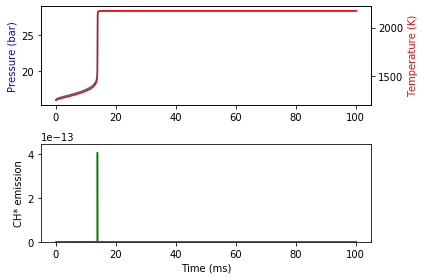

At 1250.0 K 16 bar, ignition delay time is 13.846176021422496 ms


In [13]:
get_ignition_delay_air_n2(1000/.8, 16, 1, plot=True)
plt.rcParams['figure.figsize'] = [10, 8]

In [14]:
RMG_temperatures = 1000/np.linspace(0.70,1.2,25)
pressures_bar = 16
phi = 1

RMG_results = dict()
times = []
for T in RMG_temperatures:
    t = get_ignition_delay_air_n2(T,pressures_bar, phi, plot=False)
    times.append(t)
    RMG_results[pressures_bar]=times

Reached end time 103.39 ms in 3752 steps
At 1428.5714285714287 K 16 bar, ignition delay time is 1.3550845636040014 ms
Reached end time 105.62 ms in 4541 steps
At 1387.2832369942196 K 16 bar, ignition delay time is 2.356868223851881 ms
Reached end time 100.80 ms in 4786 steps
At 1348.3146067415732 K 16 bar, ignition delay time is 3.937742346341794 ms
Reached end time 104.59 ms in 4894 steps
At 1311.4754098360656 K 16 bar, ignition delay time is 6.347685962019868 ms
Reached end time 100.77 ms in 4760 steps
At 1276.595744680851 K 16 bar, ignition delay time is 9.9077411420497 ms
Reached end time 102.29 ms in 4807 steps
At 1243.5233160621763 K 16 bar, ignition delay time is 15.0113693983575 ms
Reached end time 100.78 ms in 4604 steps
At 1212.1212121212122 K 16 bar, ignition delay time is 22.11192888609619 ms
Reached end time 100.27 ms in 4822 steps
At 1182.266009852217 K 16 bar, ignition delay time is 31.636942435149912 ms
Reached end time 100.22 ms in 4784 steps
At 1153.846153846154 K 16 

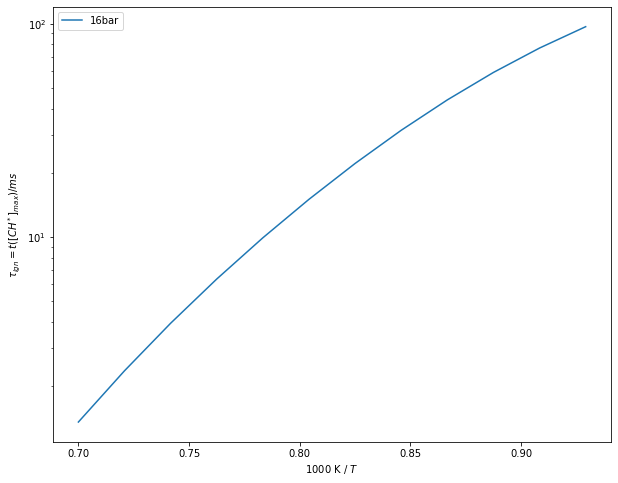

In [15]:
plt.semilogy(1000/RMG_temperatures,RMG_results[pressures_bar],label='{}bar'.format(pressures_bar))
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/ms$')
plt.rcParams['figure.figsize'] = [10, 8]

In [ ]:
import pickle
with open('ic8-RMG_no_moving_wall.pkl','wb') as fp:
    pickle.dump((RMG_temperatures, RMG_results[pressures_bar]), fp)

In [16]:
# extracted values of predicted ignition delay for iso-octane in Fig.14 
# using the docstrings
predict_ic8 = """0.657614                 0.0438935
0.660053                 0.0508193
0.668666                 0.0605986
0.674810                 0.0712038
0.682193                 0.0824521
0.690803                 0.0997690
0.695710                 0.117224
0.705556                 0.141850
0.712933                 0.169140
0.722793                 0.193028
0.730166                 0.233559
0.740019                 0.274467
0.748628                 0.332111
0.759721                 0.384622
0.765868                 0.445364
0.775710                 0.546873
0.786810                 0.615061
0.799138                 0.712339
0.806515                 0.849383
0.818843                 0.983721
0.829936                 1.13926
0.843501                 1.31950
0.852120                 1.52800
0.864449                 1.76967
0.878014                 2.04964
0.889110                 2.33921
0.900212                 2.59264
0.910061                 3.09168
0.927338                 3.52918
0.935965                 3.96890
0.942116                 4.52889
0.958153                 5.24581
0.969245                 6.07524
0.985293                 6.73451
0.993909                 7.91373
1.00872                  8.90155
1.02476                  9.86753
1.03338                  11.4268
1.04572                  12.8521
1.06423                  14.6714
1.07409                  16.9904
1.08520                  18.5574
1.10124                  21.1825
1.11357                  23.4784
1.12466                  27.5917
1.13824                  30.1389
1.14933                  35.4191
1.16290                  39.8386
1.17523                  46.1394
1.18633                  51.8925
1.19865                  61.8858
1.20728                  68.5850
1.21961                  80.6040
1.23070                  94.7255
"""

ign_times = []
temps = []

for k in predict_ic8.splitlines():
    temp, ign_time = k.split()
    temps.append(float(temp))
    ign_times.append(float(ign_time))
    
ign_times = np.array(ign_times)
temps = np.array(temps)
#print(temps, ign_times)

Text(0.5, 1.0, "Dagaut's Figure 14, iso-octane")

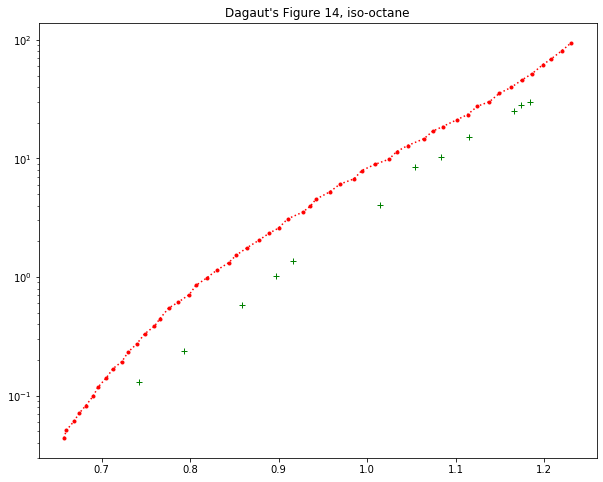

In [17]:
experiment_ic8 = """ 0.742197            0.129438
0.792731            0.238540
0.858775            0.582623
0.897119            1.02386
0.916046            1.35725
1.01424             4.07608
1.05446             8.48794
1.08368             10.3738
1.11478             15.2007
1.16585             24.9217
1.17410             28.0282
1.18433             30.0848
"""

exp_ign_times = []
exp_temps = []



for z in experiment_ic8.splitlines():
    exp_temp, exp_ign_time = z.split()
    exp_temps.append(float(exp_temp))
    exp_ign_times.append(float(exp_ign_time))
    
exp_ign_times = np.array(exp_ign_times)
exp_temps = np.array(exp_temps)

plt.semilogy(temps,ign_times, 'r.:')
plt.semilogy(exp_temps,exp_ign_times, 'g+')
plt.title("Dagaut's Figure 14, iso-octane")

<function matplotlib.pyplot.show(*args, **kw)>

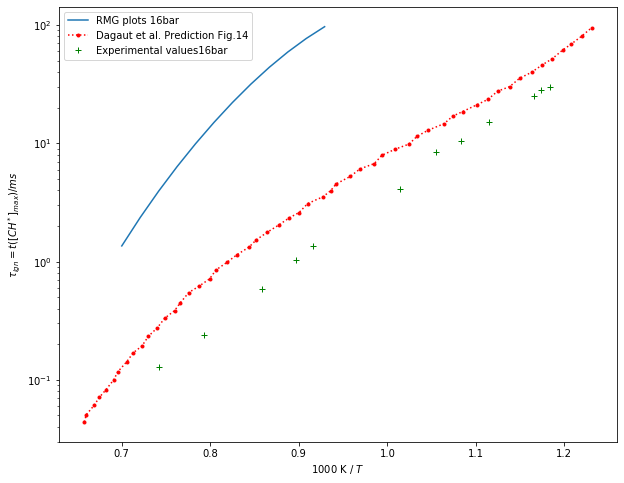

In [19]:
plt.semilogy(1000/RMG_temperatures,RMG_results[pressures_bar],label='RMG plots {}bar'.format(pressures_bar))
plt.semilogy(temps,ign_times, 'r.:', label='Dagaut et al. Prediction Fig.14'.format(pressures_bar))
plt.semilogy(exp_temps,exp_ign_times, 'g+',label='Experimental values{}bar'.format(pressures_bar))
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/ms$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.show